In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
import matplotlib.pyplot as plt
import math

# 針對物件圖像數據集的類別編列成字典
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = dict(zip(range(0, len(label_list)), label_list))


# 宣告一個影像標記的函數
def plot_images_labels(images, labels, idx, num):
    # 創造 rows x cols 的子圖
    cols = 8
    rows = math.ceil(num / cols)
    figure, ax = plt.subplots(rows, cols, figsize=(16,8))

    for i in range(0, num):
        # 鎖定子圖位置
        plt.subplot(rows, cols, 1+i)

        # 顯示 images 內第幾張圖片
        plt.imshow(images[idx])

        # 顯示 images 內第幾張圖片的標題        
        title = f"{i+1}.{label_dict[labels[idx][0]]}"
        idx += 1 

        # 一些畫圖設定  
        plt.title(title, fontsize=15) 
        plt.xticks([]); plt.yticks([])

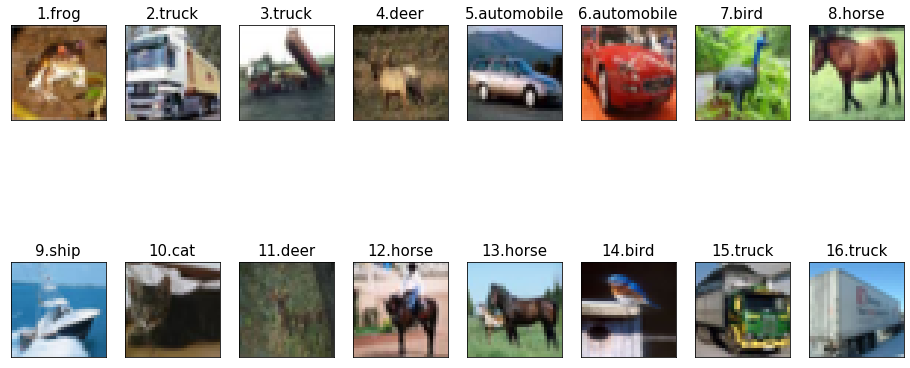

In [0]:
# 取前 16 張圖片做視覺化
batch_size = 16
images = x_train[:batch_size]
labels = y_train[:batch_size]
plot_images_labels(images, labels, idx=0, num=batch_size)

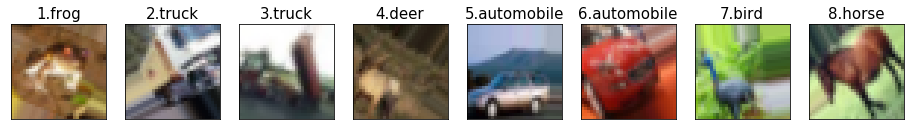

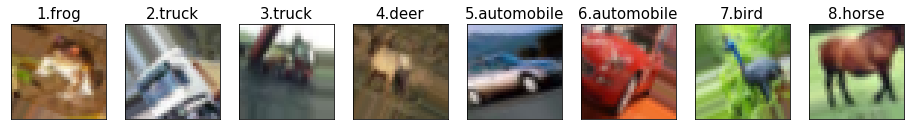

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)
datagen.fit(x_train)

for i in range(2):
    # 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
    x_train_aug, y_train_aug = next(datagen.flow(images, labels, batch_size=8, shuffle=False))

    # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int
    plot_images_labels(x_train_aug.astype("int"), y_train_aug, idx=0, num=8)

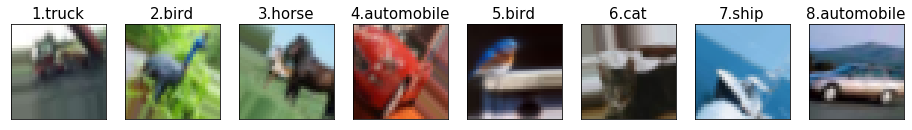

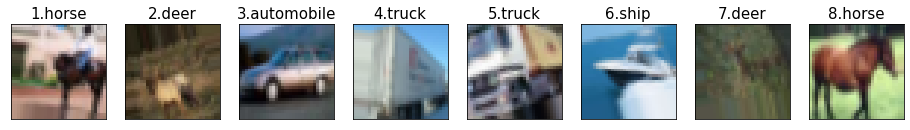

In [0]:
for i in range(2):
    # shuffle=True, 則會從訓練集內隨機抽取batch_size個樣本出來訓練(會重複抽取)
    x_train_aug, y_train_aug = next(datagen.flow(images, labels, batch_size=8, shuffle=True))

    # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int
    plot_images_labels(x_train_aug.astype("int"), y_train_aug, idx=0, num=8)

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras import optimizers
import numpy as np

In [0]:
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
weight_decay = 1e-4
batch_size_4_gen = 512

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"x_train shape: {x_train.shape}, {x_train.shape[0]} train samples")
print(f"x_test shape: {x_test.shape}, {x_test.shape[0]} test samples")

# 將資料標準化
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3), 50000 train samples
x_test shape: (10000, 32, 32, 3), 10000 test samples


In [0]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(x_train)

In [0]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003
    return lrate

In [0]:
K.clear_session()

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

# Fitting the model using a batch generator
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size_4_gen),
                              steps_per_epoch=int(np.ceil(x_train.shape[0]/batch_size_4_gen))*1.5,
                              epochs=75,
                              validation_data=(x_test,y_test),
                              callbacks=[LearningRateScheduler(lr_schedule)])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/75
147/147 [==============================] - 41s 276ms/step - loss: 3.1582 - acc: 0.3140 - val_loss: 1.8144 - val_acc: 0.4095
Epoch 2/75
147/147 [==============================] - 33s 222ms/step - loss: 1.5379 - acc: 0.4764 - val_loss: 2.0189 - val_acc: 0.4522
Epoch 3/75
147/147 [==============================] - 32s 220ms/step - loss: 1.2712 - acc: 0.5648 - val_loss: 1.4829 - val_acc: 0.5410
Epoch 4/75
147/147 [==============================] - 33s 226ms/step - loss: 1.1174 - acc: 0.6242 - val_loss: 1.1042 - val_acc: 0.6394
Epoch 5/75
147/147 [==============================] - 33s 222ms/step - loss: 1.0113 - acc: 0.6603 - val_loss: 0.9165 - val_acc: 0.7017
Epoch 6/75
147/147 [==============================] - 33s 224ms/step - loss: 0.9422 - acc: 0.6877 -

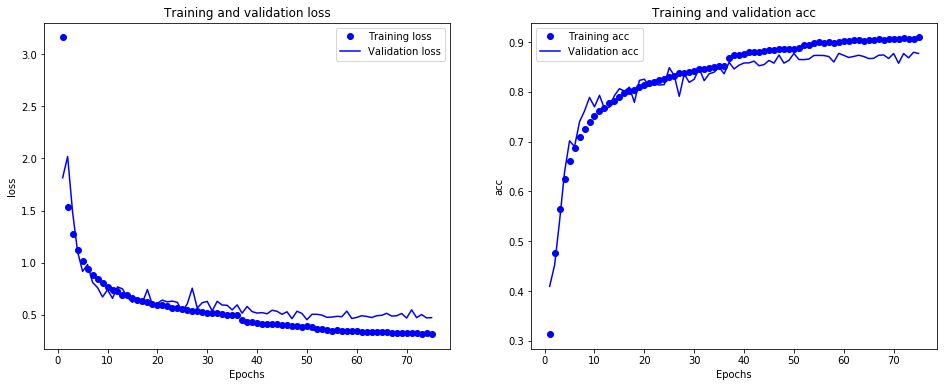

In [0]:
# Displaying curves of loss and accuracy during training
epochs = range(1, len(history.history['loss']) + 1)

rows, cols = 1, 2
figure, ax = plt.subplots(rows, cols, figsize=(16,6))

for i, metric in enumerate(['loss', 'acc']):
    plt.subplot(1, 2, i+1)
    plt.plot(epochs, history.history[metric], 'bo', label=f"Training {metric}")
    plt.plot(epochs, history.history['val_'+metric], 'b', label=f"Validation {metric}")
    plt.title(f"Training and validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()